<a href="https://colab.research.google.com/github/changhorang/SSAC_study/blob/main/DL/02_%EC%B2%AB%EB%B2%88%EC%A7%B8%20%EB%94%A5%EB%9F%AC%EB%8B%9D-MLP%20%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install pydot pydotplus graphviz
# 설치후 jupyter notebook 은 껐다 켜야 한다.

# Keras 개발 Process

1. 입력 텐서(X)와 출력 텐서(y)로 이뤄진 **훈련 데이터를 정의**

2. 입력과 출력을 연결하는 Layer(층)으로 이뤄진 **네트워크(모델)을 정의**
    - Sequential 방식: 순서대로 쌓아올린 네트워크로 이뤄진 모델을 생성하는 방식
    - Functional API 방식: 다양한 구조의 네트워크로 이뤄진 모델을 생성하는 방식
    - Subclass 방식: 네트워크를 정의하는 클래스를 구현.
    

3. **모델 Compile(컴파일)**
    - 모델이 Train(학습)할때 사용할 손실함수(Loss Function), 최적화기법(Optimizer), 학습과정을 모니터링할 평가지표(Metrics)를 설정
    
    > Compile: 실행할 수 있는 상태로 만들어 주는 것.

4. **Training(학습/훈련)**
    - Train dataset을 이용해 모델을 Train 시킨다.

# MNIST 이미지 분류 
- ### [MNIST](https://ko.wikipedia.org/wiki/MNIST_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B2%A0%EC%9D%B4%EC%8A%A4)(Modified National Institute of Standards and Technology) database
- 흑백 손글씨 숫자 0-9까지 10개의 범주로 구분해놓은 데이터셋
- 하나의 이미지는 28 * 28 pixel 의 크기
- 6만개의 Train 이미지와 1만개의 Test 이미지로 구성됨.

##### import

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

##### MNIST dataset Loading

In [3]:
(train_image, train_label), (test_image, test_label) = keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
print(train_image.shape, test_image.shape) 
# image : (num, height, width)
# 결과가 (10000, 28, 28, 3) 이었다면 color image

(60000, 28, 28) (10000, 28, 28)


In [5]:
print(train_label.shape, test_label.shape)
# target : (Ground Truth, label)

(60000,) (10000,)


In [6]:
type(train_image), type(train_label), train_label.dtype

(numpy.ndarray, numpy.ndarray, dtype('uint8'))

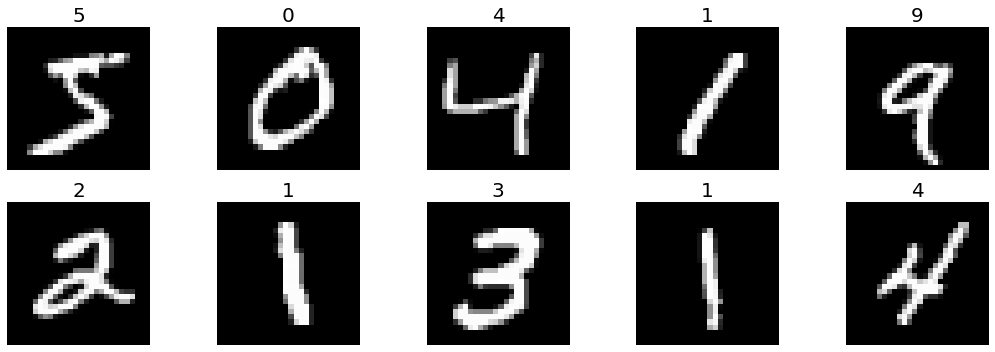

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

N = 10
for i in range(N):
    plt.subplot(2, int(N/2), i+1)
    plt.imshow(train_image[i], cmap='gray')
    plt.title(str(train_label[i]), fontsize=20) # int8 => str 변환
    plt.axis('off')
    
plt.tight_layout()
plt.show()

## 네트워크(모델) 구현
- Network : 전체 모델 구조

In [10]:
model = keras.Sequential()

# input layer : input data의 shape을 지정 (28, 28)
model.add(keras.layers.InputLayer((28,28))) 

# flatten : 2차원 (N차원) 배열(tensor)을 1차원 배열(tensor)로 변환
model.add(keras.layers.Flatten())  

# feature extractor
# 256, 128 -> unit (node, neuron)의 개수 : 1개 unit은 logisticRegression model 1개와 동일
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))

# 출력 layer
# unit 수 (10) : 출력 결과 개수와 동일 (0 ~ 9일 확률 출력)
model.add(keras.layers.Dense(10, activation='softmax'))

# 다른 표현 방식 (list를 만들어 추가하는 방식)
model2 = keras.Sequential([
                        keras.layers.InputLayer((28,28)),
                        keras.layers.Flatten(),
                        keras.layers.Dense(256, activation='relu'),
                        keras.layers.Dense(128, activation='relu'),
                        keras.layers.Dense(10, activation='softmax')
])

In [11]:
model.summary()
# output shape: 각 layer의 출력(배열) 형태
# (None, 784) - 'None' : data의 개수(미정) / '784' : 데이터 1개가 784개 원소인 1차원 data

# Param : 학습 시킬 파라미터 (weight, bias)의 개수

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               200960    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


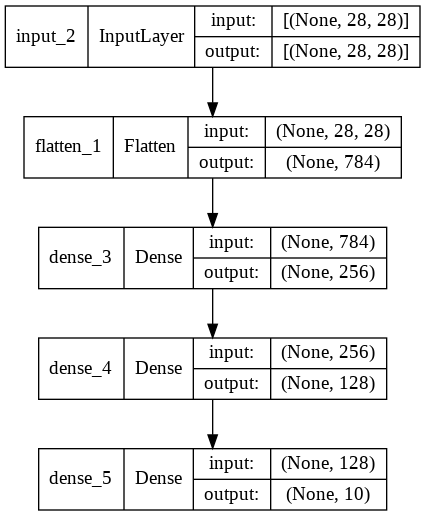

In [12]:
# model의 구조를 graphviz를 이용해 시각화 (plot_model)
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_shapes.png', show_shapes=True)

## 컴파일 단계
- 정의된 네트워크 모델에 학습을 위한 추가 설정을 한다.
    - Optimizer
    - 손실함수
    - 평가지표

In [13]:
model.compile(optimizer='adam', # 최적화 방법 (parameter update)
              loss='categorical_crossentropy', # 손실 함수 정의 : 오차 구하는 함수
              metrics=['accuracy']) # 평가지표 : 학습에 대한 평가를 중간에 출력 (loss & 지정한 평가 지표(accuracy))

## 데이터 준비
- X (Input Data Image)
    - 0 ~ 1 사이의 값으로 정규화 시킨다.
- y (Output Data)
    - one hot encoding 처리
        - Label이 다중분류(Multi class classification)일 경우 One Hot Encoding 한다.
    - Keras의 onehot encoding 처리 함수
        - tensorflow.keras.utils.to_categorical()

In [14]:
print(np.min(train_image), np.max(train_image), train_image.dtype, sep=', ')

0, 255, uint8


##### input image(X)를 정규화. 
- 이미지를 0 ~ 1 로 정규화 하고 타입을 float32로 변환

In [15]:
X_train = (train_image/255.).astype(np.float32)
X_test = (test_image/255.).astype(np.float32)

In [17]:
print(np.min(X_train), np.max(X_train), X_train.dtype, sep=', ')

0.0, 1.0, float32


##### label(y)를 one hot encoding

In [18]:
print(train_label.shape, test_label.shape)
train_label[:5]

(60000,) (10000,)


array([5, 0, 4, 1, 9], dtype=uint8)

In [19]:
# one_hot encoding
y_train = keras.utils.to_categorical(train_label)
y_test = keras.utils.to_categorical(test_label)

In [20]:
y_train[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [21]:
print(y_train.shape, y_test.shape)

(60000, 10) (10000, 10)


## 학습 (fit)
- model.fit()
    - 모델 학습 메소드. 
    - 학습과정의 Log를 History 객체로 반환한다.
- History : train 시 에폭별 평가지표값들을 모아서 제공.    

In [22]:
# Epoch : train dataset 전체를 1번 학습
# step : 1번 최적화
# 총 step 수 : data 크기/batch_size*epochs

hist = model.fit(X_train, y_train, 
                  epochs=10,  # epoch 수
                  batch_size=100, # 최적화 단위, batch_size만큼의 data를 학습한 뒤 최적화함
                  validation_split=0.3 # tranin set을 검증 dataset나눌 비율
                  )

Epoch 1/10
420/420 [==============================] - 3s 4ms/step - loss: 0.3034 - accuracy: 0.9128 - val_loss: 0.1707 - val_accuracy: 0.9498
Epoch 2/10
420/420 [==============================] - 1s 3ms/step - loss: 0.1177 - accuracy: 0.9652 - val_loss: 0.1147 - val_accuracy: 0.9651
Epoch 3/10
420/420 [==============================] - 1s 3ms/step - loss: 0.0748 - accuracy: 0.9781 - val_loss: 0.1020 - val_accuracy: 0.9691
Epoch 4/10
420/420 [==============================] - 1s 3ms/step - loss: 0.0529 - accuracy: 0.9838 - val_loss: 0.1105 - val_accuracy: 0.9677
Epoch 5/10
420/420 [==============================] - 1s 3ms/step - loss: 0.0385 - accuracy: 0.9879 - val_loss: 0.1104 - val_accuracy: 0.9682
Epoch 6/10
420/420 [==============================] - 1s 3ms/step - loss: 0.0272 - accuracy: 0.9920 - val_loss: 0.1147 - val_accuracy: 0.9690
Epoch 7/10
420/420 [==============================] - 1s 3ms/step - loss: 0.0228 - accuracy: 0.9927 - val_loss: 0.1233 - val_accuracy: 0.9676
Epoch 

In [23]:
# trainset : loss, {accuracy}, val_loss, {val_accuracy} - 지정해서 나온 값

In [24]:
type(hist)

keras.callbacks.History

In [26]:
type(hist.history)

dict

In [27]:
hist.history # dict 형태로 hist return

{'accuracy': [0.9128333330154419,
  0.965238094329834,
  0.9781190752983093,
  0.9838095307350159,
  0.987928569316864,
  0.9919762015342712,
  0.9926905035972595,
  0.9933571219444275,
  0.9948333501815796,
  0.9958333373069763],
 'loss': [0.3033634424209595,
  0.11769848316907883,
  0.07479894906282425,
  0.05290234461426735,
  0.03845982998609543,
  0.027151869609951973,
  0.022780366241931915,
  0.020114151760935783,
  0.015538179315626621,
  0.013867287896573544],
 'val_accuracy': [0.949833333492279,
  0.9651111364364624,
  0.9690555334091187,
  0.9677222371101379,
  0.9681666493415833,
  0.968999981880188,
  0.967555582523346,
  0.9712777733802795,
  0.9722222089767456,
  0.9712222218513489],
 'val_loss': [0.17067354917526245,
  0.11465016007423401,
  0.10200276225805283,
  0.11049393564462662,
  0.11041027307510376,
  0.11466621607542038,
  0.12330827862024307,
  0.1117316409945488,
  0.1111374944448471,
  0.11860562115907669]}

##### History 시각화

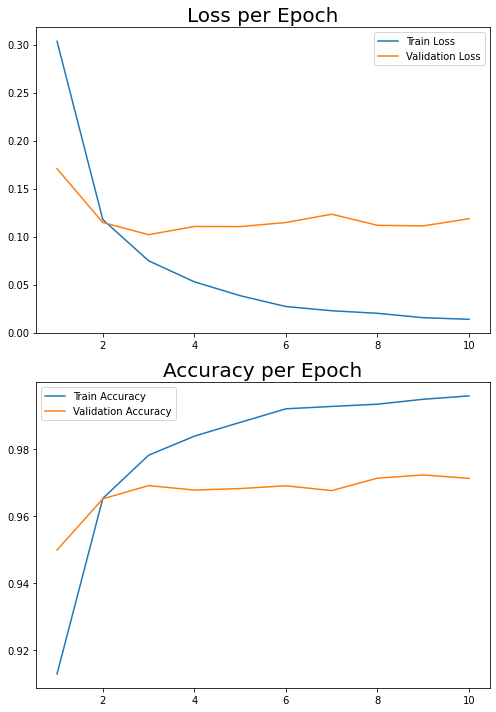

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,10))

# loss, val_loss
plt.subplot(2,1,1)
plt.plot(range(1,11), hist.history['loss'], label='Train Loss')
plt.plot(range(1,11), hist.history['val_loss'], label="Validation Loss")
plt.title("Loss per Epoch", fontsize=20)
plt.legend()

# accuracy, val_accuracy
plt.subplot(2,1,2)
plt.plot(range(1,11), hist.history['accuracy'], label='Train Accuracy')
plt.plot(range(1,11), hist.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy per Epoch", fontsize=20)

plt.legend()
plt.tight_layout()
plt.show()

# epoch이 진행되면 validation의 성능은 좋아지다가 어느 순간 부터 정체 또는 나빠짐. 이때가 overfitting이 발생했다고 볼 수 있음

## 테스트셋 평가

In [29]:
# model.evaluate() : 평가 함수
# loss와 compile시 지정한 metrics 값을 출력
test_loss, test_acc = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0931 - accuracy: 0.9754


In [30]:
print(test_loss, test_acc)

0.0931435152888298 0.9753999710083008


## 새로운 데이터 추론
- 새로운 데이터를 추론하기 전에 학습데이터에 했던 전처리과정을 동일하게 적용 한 뒤 추론한다.

### 추론 메소드
- predict()
    - **분류:** 각 클래스 별 확률 반환
    - **회귀:** 최종 예측 결과
- <del>predict_classes()</del>
    - 분류 문제에서 클래스(범주값) 반환
    - tensorflow 2.3 부터 deprecated되고 2.6버전에서 제거됨.
- 이진 분류(binary classification)
    - `numpy.where(model.predict(x) > 0.5, 1, 0).astype("int32")`
- 다중클래스 분류(multi-class classification)
    - `numpy.argmax(model.predict(x), axis=1)`

In [31]:
new_image = X_test[:5] # 0 ~ 1 정규화 이미 되어 있음 (원래는 정규화 해야함)
new_image.shape

(5, 28, 28)

In [32]:
result = model.predict(new_image)
result.shape

(5, 10)

In [33]:
result[0]

array([3.2524988e-10, 8.9404333e-09, 5.7328148e-08, 2.3923106e-04,
       8.7247735e-12, 1.0756371e-07, 5.7071839e-13, 9.9975461e-01,
       1.9904508e-07, 5.7952716e-06], dtype=float32)

In [34]:
result_label = np.argmax(result, axis=-1)

In [35]:
result_label

array([7, 2, 1, 0, 4])